In [1]:
ENV["GKS_ENCODING"] = "utf-8"
using NLsolve
using Plots
using BenchmarkTools
using Distributed
using IntervalArithmetic, IntervalRootFinding

include("/home/julian/Hamburg/LadderDGA/run.jl");

using 9 workers.
      From worker 5:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`


 Activating environment at `~/Hamburg/LadderDGA/Project.toml`


      From worker 4:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`
      From worker 7:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`
      From worker 3:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`
      From worker 2:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`
      From worker 8:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`
      From worker 6:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`
      From worker 9:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`


┌ Warning: ArgParse not working with jupyter notebooks
└ @ Main.LadderDGA /home/julian/Hamburg/LadderDGA/src/DepsInit.jl:47
┌ Warning: Check U and Beta consistency in chi_dir/gamma_dir
└ @ Main.LadderDGA /home/julian/Hamburg/LadderDGA/src/DepsInit.jl:48
┌ Info: Reading Inputs...
└ @ Main.LadderDGA /home/julian/Hamburg/LadderDGA/src/DepsInit.jl:50
┌ Info: Reading Fortran Input, this can take several minutes.
└ @ Main.LadderDGA /home/julian/Hamburg/LadderDGA/src/IO.jl:95
┌ Info: Done Reading Gamma
└ @ Main.LadderDGA /home/julian/Hamburg/LadderDGA/src/IO.jl:109
┌ Info: Done Reading chi
└ @ Main.LadderDGA /home/julian/Hamburg/LadderDGA/src/IO.jl:111
┌ Info: loading from 
│   env.inputVars = vars.jld
└ @ Main.LadderDGA /home/julian/Hamburg/LadderDGA/src/helpers.jl:67
┌ Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
└ @ Main.LadderDGA /home/julian/Hamburg/LadderDGA/src/helpers.jl:77
┌ Info: Inputs Read. Starting Computation.
│ Found usable intervals for local 

[ Info: Done.


In [4]:
using FFTW
stripped_type(t) = (t |> typeof |> Base.typename).wrapper
sum_drop(arr::AbstractArray) = sum(a,dims=dims)[[(i in dims ? 1 : axes(a,i)) for i in 1:ndims(a)]...]

# ================== FFT + Intervals Workaround ==================
lo(arr::Array{Interval{Float64}}) = map(x->x.lo,arr)
hi(arr::Array{Interval{Float64}}) = map(x->x.hi,arr) 
lo(arr::Array{Complex{Interval{Float64}}}) = map(x->x.lo,real.(arr)) .+ map(x->x.lo,imag.(arr)) .* im
hi(arr::Array{Complex{Interval{Float64}}}) = map(x->x.hi,real.(arr)) .+ map(x->x.hi,imag.(arr)) .* im
cmplx_interval(x::Tuple{Complex{Float64},Complex{Float64}}) = Complex(interval(minimum(real.(x)),maximum(real.(x))),
                                                                      interval(minimum(imag.(x)),maximum(imag.(x))))
AbstractFFTs.fft(arr::Array{Interval{Float64}}) = map(x->interval(minimum(x),maximum(x)),zip(fft(lo(arr)), fft(lo(arr))))
AbstractFFTs.fft(arr::Array{Complex{Interval{Float64}}}) = map(x->cmplx_interval(x),zip(fft(lo(arr)), fft(hi(arr))))
AbstractFFTs.ifft(arr::Array{Interval{Float64}}) = map(x->interval(minimum(x),maximum(x)),zip(ifft(lo(arr)), ifft(lo(arr))))
AbstractFFTs.ifft(arr::Array{Complex{Interval{Float64}}}) = map(x->cmplx_interval(x),zip(ifft(lo(arr)), ifft(hi(arr))))


In [1]:
test1 = (-4:0.1:4) .^2 
test1_fft = fft(test1);

LoadError: UndefVarError: fft not defined

In [34]:
test1_int = map(x -> interval(x-0.01,x+0.01) + interval(-0.001,0.001)im, test1);
test1_int_fft = fft(test1_int);

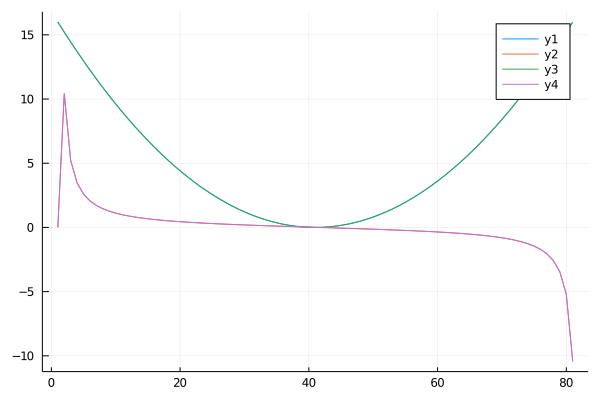

In [42]:
plot(test1)
plot!(imag.(test1_fft))
plot!(mid.(real.(test1_int)))
plot!(mid.(imag.(test1_int_fft)))

In [135]:
function EP_fit(λspi, λchi)
    sP = LadderDGA.simParams
    mP = LadderDGA.modelParams
    gridShape = repeat([sP.Nk], mP.D)
    norm = mP.β * sP.Nk^mP.D
    νGrid = 0:sP.n_iν-1
    Σ_hartree = mP.n * mP.U/2
    E_pot_tail_c = (mP.U^2 * 0.5 * mP.n * (1-0.5*mP.n) .+ Σ_hartree .* (LadderDGA.ϵqGrid .+ Σ_hartree .- mP.μ))
    E_pot_tail = E_pot_tail_c' ./ (LadderDGA.iν_array(mP.β, νGrid) .^ 2)
    E_pot_tail_inv = sum((mP.β/2)  .* [Σ_hartree .* ones(size(LadderDGA.ϵqGrid)), (-mP.β/2) .* E_pot_tail_c])

    transform = LadderDGA.reduce_kGrid ∘ LadderDGA.ifft_cut_mirror ∘ ifft 
    transformK(x) = fft(LadderDGA.expand_kGrid(LadderDGA.qIndices, x))
    transformG(x) = reshape(x, gridShape...)
    usable_ω = intersect(nlQ_sp.usable_ω, nlQ_ch.usable_ω)
    n_iω_usable = (-sP.n_iω:sP.n_iω)[usable_ω]
    Gνω = LadderDGA.Gfft_from_Σ(LadderDGA.Σ_loc_pos, LadderDGA.ϵkGrid, -sP.n_iω:(sP.n_iν+sP.n_iω-1), mP)
    Gνω_usable = LadderDGA.Gfft_from_Σ(LadderDGA.Σ_loc_pos, LadderDGA.ϵkGrid, first(n_iω_usable):(sP.n_iν+last(n_iω_usable)-1), mP)
    Σ_ladder_ω = Array{Complex{Interval{Float64}},3}(undef, length(usable_ω), length(1:sP.n_iν), length(LadderDGA.qIndices)) 
    tmp = Array{Complex{Float64},3}(undef, length(usable_ω), size(bubble,2), sP.n_iν)
    LadderDGA.Σ_internal2!(tmp, usable_ω, bubble, view(LadderDGA.FUpDo,:,(sP.n_iν+1):size(LadderDGA.FUpDo,2),:), false, nothing)
    χsp_λ = Array(LadderDGA.χ_λ(nlQ_sp.χ[usable_ω,:], λspi))
    χch_λ = Array(LadderDGA.χ_λ(nlQ_ch.χ[usable_ω,:], λchi))
    ωsum_indices = usable_ω # 1:sP.n_iω
    LadderDGA.Σ_internal!(Σ_ladder_ω, 1:length(usable_ω), χsp_λ, χch_λ,
                view(nlQ_sp.γ,usable_ω,:,(sP.n_iν+1):size(nlQ_sp.γ,3)), 
                view(nlQ_ch.γ,usable_ω,:,(sP.n_iν+1):size(nlQ_ch.γ,3)),
                Gνω_usable, tmp, mP.U, transformG, transformK, transform)
    Σ_new = mP.U .* LadderDGA.sum_freq(Σ_ladder_ω, [1], false, 1.0, weights=nothing)[1,:,:] ./ norm;
    Σ_corr = Σ_new .- Σ_ladderLoc .+ LadderDGA.Σ_loc_pos[eachindex(Σ_ladderLoc)]
    G_corr = LadderDGA.flatten_2D(LadderDGA.G_from_Σ(Σ_corr .+ Σ_hartree, LadderDGA.ϵqGrid, νGrid, mP));
    E_pot  = LadderDGA.calc_E_pot(G_corr, Σ_corr .+ Σ_hartree, E_pot_tail, E_pot_tail_inv, LadderDGA.qMultiplicity, norm)
    lhs = mP.U * sum(real.(χch_λ .- χsp_λ)) ./ norm
    return lhs, E_pot
end

EP_fit (generic function with 2 methods)

In [ ]:
includ

In [134]:
roots(x-> EP_fit(0.0, x), -100..100, Bisection, 1e-2)

LoadError: MethodError: no method matching Σ_internal2!(::Array{Complex{Float64},3}, ::UnitRange{Int64}, ::SharedArray{Complex{Float64},3}, ::SubArray{Complex{Float64},3,Array{Complex{Float64},3},Tuple{Base.Slice{Base.OneTo{Int64}},UnitRange{Int64},Base.Slice{Base.OneTo{Int64}}},false}, ::Bool, ::Nothing)
Closest candidates are:
  Σ_internal2!(!Matched::SharedArray{Complex{Float64},3}, ::Any, ::SharedArray{Complex{Float64},3}, ::SubArray, ::Bool, ::Any) at /home/julian/Hamburg/LadderDGA/src/ladderDGATools.jl:69

In [130]:
λch_range_c2 = -0.5:0.01:0.5
λsp_range_c2 = -1:0.1:1
rhs_overview = Array{Float64,2}(undef, length(λch_range_c2),length(λsp_range_c2));
lhs_overview = Array{Float64,2}(undef, length(λch_range_c2),length(λsp_range_c2));
for i in (1:length(λch_range_c2))
    λch_i = λch_range_c2[i]
    for (j,λsp_i) in enumerate(λsp_range_c2)
        lhs, E_pot = EP_fit(λsp_i, λch_i)
        lhs_overview[i,j] = lhs
        rhs_overview[i,j] = mid.(E_pot)
        print("\r", i, " ", j, " = ",i*j," of ",length(λch_range_c2)," x ",length(λsp_range_c2), " = ", length(λch_range_c2)*length(λsp_range_c2))   
    end
end


38 17 = 646 of 101 x 21 = 2121

LoadError: On worker 4:
SystemError: shm_open() failed for /jl591301yvmGrO0Ds7KgrI6zShH0: Too many open files
#systemerror#49 at ./error.jl:168
#systemerror#48 at ./error.jl:167 [inlined]
systemerror at ./error.jl:167 [inlined]
_shm_mmap_array at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/SharedArrays/src/SharedArrays.jl:679
shm_mmap_array at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/SharedArrays/src/SharedArrays.jl:649
#6 at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/SharedArrays/src/SharedArrays.jl:128
#103 at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Distributed/src/process_messages.jl:290
run_work_thunk at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Distributed/src/process_messages.jl:79
run_work_thunk at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Distributed/src/process_messages.jl:88
#96 at ./task.jl:356

[0.182736, 0.182737]

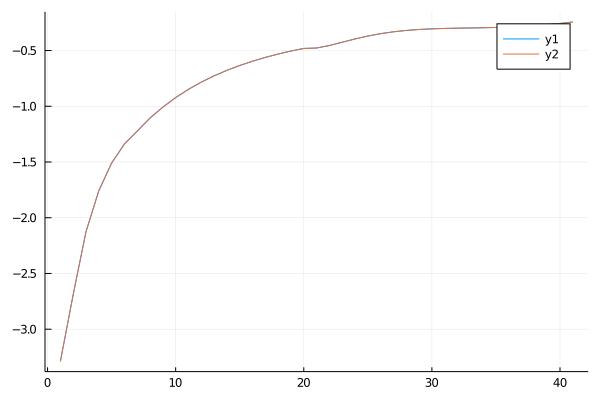

In [94]:
plot(mid.(imag.(Σ_new[:,1])))
plot!(mid.(imag.(tttt[:,1])))

In [72]:
tttt = copy(Σ_new);